In [1]:
import numpy as np
import interp as tc # Change in name: Tricubic
import torch
from glob import glob
from utils.data_loading import read_p_thermo, middle_point
from scipy.interpolate import RegularGridInterpolator
from utils.laplace import (
    compute_variable_laplacian,
    compute_volume_filter_mask_cube_root,
    compute_direction_cell_dependant_laplacian,
    compute_fixed_laplacian, pad_global_field,
    cell_dependant_laplacian_filter_width
)
from utils.blur import convolve_box_kernel_regular, convolve_box_kernel_k
from visualisation.visual_utils import visualize_x_y_z_slices_n
from datahandling.dataplotter import matplotlib_latex_params
import matplotlib.pyplot as plt
from utils.utils import shape
matplotlib_latex_params()

In [2]:
%matplotlib inline

In [3]:
# USEFUL MESH STUFF
delta = h = 15e-3
ndns = (384, 384, 266)
nles = (48, 48, 50)
nn = 2
inner = slice(nn, -nn)
inner_3 = (inner, inner, inner)


path = "/home/zatout/Documents/These_yanis/Reunion_10012022/dns_180/"
path_coords = glob(path+"dns_lata_1.sauv.lata.grid_geom2.coord*")
path_coords.sort()
p_thermo = read_p_thermo(
    path+"dns_lata_0.sauv",
    dtype=np.float32
)
rho = np.fromfile(
    path+"dns_lata_1.sauv.lata.0.RHO",
    dtype=np.float32
)
r_air = 287.058
T_dns = p_thermo/(rho*r_air)
T_dns = T_dns.astype(np.float64)
T_dns = T_dns.reshape(*ndns, order="F")

coord_vertex = [np.fromfile(g, dtype=np.float32) for g in path_coords]
steps_vertex = [np.diff(g) for g in coord_vertex]
steps_vertex_torch = [torch.tensor(g) for g in steps_vertex]
steps_vertex_torch = [steps_vertex_torch[0][0], steps_vertex_torch[1][0], steps_vertex_torch[2]]
coord = [middle_point(c) for c in coord_vertex]
coord_inner = [c[inner] for c in coord]
steps = [np.diff(c) for c in coord]
steps = [torch.tensor(steps[0][0]), torch.tensor(steps[1][0]), steps[2]]
steps[-1] = torch.from_numpy(steps[-1])
coord_les = [np.linspace(i.min(), i.max(), n)
             for i, n in zip(coord, nles)]
steps_les = [np.linspace(i.min(), i.max(), n, retstep=True)
             for i, n in zip(coord, nles)]
steps_les = [s[1] for s in steps_les]
steps_les_torch = [torch.tensor(s) for s in steps_les]

les_3 = np.meshgrid(*coord_les)
les_3 = np.concatenate([ss.ravel()[np.newaxis]
                       for ss in les_3]).T
dns_3 = np.meshgrid(*coord)
dns_3 = np.concatenate([ss.ravel()[np.newaxis]
                       for ss in dns_3]).T
coord_float64 = [c.astype("float64") for c in coord]


In [4]:
def error_profile_quantification_order_1(x, y):
    error = np.abs(x - y)
    return np.mean(error, axis = (0, 1))
def error_profile_quantification_general(x):
    return np.mean(error, axis = (0, 1))
def compute_rms(x):
    return np.sqrt(np.mean(x**2, axis=(0, 1)) - np.mean(x, axis=(0, 1))**2)
def compute_rms_diff(x, y):
    xrms = compute_rms(x)
    yrms = compute_rms(y)
    return np.abs((xrms-yrms)/xrms)
def compute_gradient_error(x, y, mesh):
    gradx = np.gradient(x, *mesh, edge_order=2)
    grady = np.gradient(y, *mesh, edge_order=2)
    return [error_profile_quantification_order_1(gx, gy) for gx, gy in zip(gradx, grady)]
def compute_all_errors(x, y, mesh):
    error_profile = error_profile_quantification_order_1(x, y)
    rms_profile = compute_rms_diff(x, y)
    gradient_profile = compute_gradient_error(x, y, mesh)
    return error_profile, rms_profile, gradient_profile

In [5]:
spline = tc.csp3d_open(*coord_float64, *ndns, T_dns.reshape(-1))


Interpolation on (x, y, z) =  $48 \times 50 \times 48$

$
\Delta_x ^+ = 68;
\Delta_y ^+ = 0.5 - 25;
\Delta_z ^+ = 34
$


In [6]:
#  Interpolation of the DNS on the regularly spaced LES grid
T_dns_on_les_field = tc.eval_all_spline_3d(
    les_3, *coord_float64, ndns, np.ascontiguousarray(T_dns).reshape(-1), spline).reshape(*nles)


In [7]:
filter_size = 3
filter_size_torch = torch.tensor(filter_size)


We filter the DNS interpolated on the LES mesh

In [8]:
#from utils.laplace import *
#from utils.blur import *
#x, dx = np.linspace(0, 2*np.pi, 266, retstep=True)
#y, dy = np.linspace(0, 2*np.pi, 266, retstep=True)
#z, dz = coord[-1]/h * np.pi, np.diff(coord[-1]/h * np.pi)
#zvertex, dzvertex = coord_vertex[-1]/h*np.pi, np.diff(coord_vertex[-1]/h*np.pi)
#XX, YY, ZZ = np.meshgrid(x, y, z)
#f = np.cos(XX) + np.cos(YY) + np.cos(ZZ)
#fpad = pad_global_field(f, 1)
#lapf = variable_laplacian(
#    fpad, 
#    dx,
#    dy,
#    dz,
#    torch.tensor(z),
#    torch.tensor(dzvertex)
#)
##visualize_x_y_z_slices_n(f, -lapf)
##visualize_x_y_z_slices_n(np.zeros_like(f), f+lapf.numpy())
#print((f + lapf.numpy())[2:-2, 2:-2, 2:-2].min())
#print((f + lapf.numpy())[2:-2, 2:-2, 2:-2].max())
#kkk = 3
#plt.hist(np.log10((f + lapf.numpy())[kkk:-kkk, kkk:-kkk, kkk:-kkk].flatten()))

Define the inner DNS field for error quantification in the context of laplacian

In [9]:
T_dns_inner = T_dns[inner_3]

In [10]:
T_LES = convolve_box_kernel_regular(
    T_dns_on_les_field, filter_size=filter_size_torch, spacing=steps_les
)

In [11]:
les_filter_size = np.array([s * filter_size for s in steps_les ])

In [12]:
les_filter_size

array([0.0119387 , 0.00596935, 0.00182642])

$\langle T  \rangle_{\text{RMS}} = \sqrt{\langle T ^2 \rangle - \langle T  \rangle ^2} $ 

Simple linear interpolation on the DNS grid

In [13]:
# Linear interpolation on DNS grid of T interpolated on the LES grid
linear_interpolator = RegularGridInterpolator(
    coord_les, T_LES, method="linear"
)
# "gros" T_{DNS}
# T LES LINEARLY INTERPOLATED ON DNS MESH
T_LES_fine = T_gro = linear_interpolator(dns_3).reshape(*ndns)


$T_{LES}$ linearly interpolated onto DNS field
$\epsilon = \Big|\frac{T_{\text{LES}}^{\text{fine}} - T_{DNS}}{T_{DNS}} \Big|$

In [14]:
eps_profile_lin_interp, rms_error_profile_lin_interp, grad_error_profile_lin_interp = compute_all_errors(T_dns, T_gro, coord)

We define $C = \frac{\overline{\Delta}^2}{24}$, where $\overline{\Delta} = \sqrt[3]{\bar{\Delta_x} \bar{\Delta_y} \bar{\Delta_z}}$

$\Delta = \frac{\partial ^2}{\partial x^2} \frac{\partial ^2}{\partial y^2} \frac{\partial ^2}{\partial z^2}$ 

We then do the following:

$T_{\text{recon}} = (Id + C \Delta) \overline{T}
$

In [15]:
#volumic_mask = compute_volume_filter_mask_cube_root(*steps, filter_size, ndns).numpy()

C = (np.cbrt(np.prod(les_filter_size))**2)/24

In [16]:
# lap_T_sqrt3_dx_dy_dz = compute_fixed_laplacian(torch.from_numpy(T_LES), *steps_les)
lap_T_sqrt3_dx_dy_dz = compute_variable_laplacian(
    torch.from_numpy(T_gro),
    dx=steps[0],
    dy=steps[1],
    dz=steps[2],
    z=torch.tensor(coord[-1]),
    dzvertex=steps_vertex_torch[-1]
)


In [17]:
T_dns_reconstructed_laplacian = (T_gro + C * lap_T_sqrt3_dx_dy_dz)[inner, inner, inner]

$\epsilon = \Big|\frac{T_{\text{recon}}^{\text{fine}} - T_{DNS}}{T_{DNS}} \Big|$

In [18]:
eps_profile_recon_lap1, rms_error_profile_lap1, grad_error_profile_lap1 = compute_all_errors(T_dns_inner, T_dns_reconstructed_laplacian, coord_inner)


Now, we define $C = \frac{1}{24}$, and we give $\Delta = \Delta_x ^2\frac{\partial ^2}{\partial x^2} \Delta_y^2\frac{\partial ^2}{\partial y^2} \Delta_z^2\frac{\partial ^2}{\partial z^2}$ 

In [19]:
lap_T_delta_filtre_dxi = cell_dependant_laplacian_filter_width(
    pad_global_field(torch.from_numpy(T_gro), 1),
    dx=steps[0],
    dy=steps[1],
    dz=steps[2],
    z=torch.tensor(coord[-1]),
    dzvertex=steps_vertex_torch[-1],
    filter_width_x = les_filter_size[0],
    filter_width_y = les_filter_size[1],
    filter_width_z = les_filter_size[2]
).numpy()

In [20]:
T_dns_reconstructed_laplacian_cell_filter = (T_gro + (1/24) * lap_T_delta_filtre_dxi)[inner_3]

In [21]:
eps_profile_recon_lap2, rms_error_profile_lap2, grad_error_profile_lap2 = compute_all_errors(T_dns_inner, T_dns_reconstructed_laplacian_cell_filter, coord_inner)

We give the following decomposition: 
$T = \overline{T} + T'$

In that case:
$T' = T - \overline{T}$
and approximately:
$T' \approx \overline{T} - \overline{\overline{T}}$

Then we can say:
$
T \approx 2 \overline{T} - \overline{\overline{T}}
$

In [22]:
T_double_filtered = convolve_box_kernel_k(T_gro, filter_size, steps_vertex_torch)
T_scale_sim = 2*T_gro - T_double_filtered

In [23]:
error_profile_scale_sim, rms_error_profile_scale_sim, grad_error_profile_scale_sim = compute_all_errors(T_dns, T_scale_sim, coord)

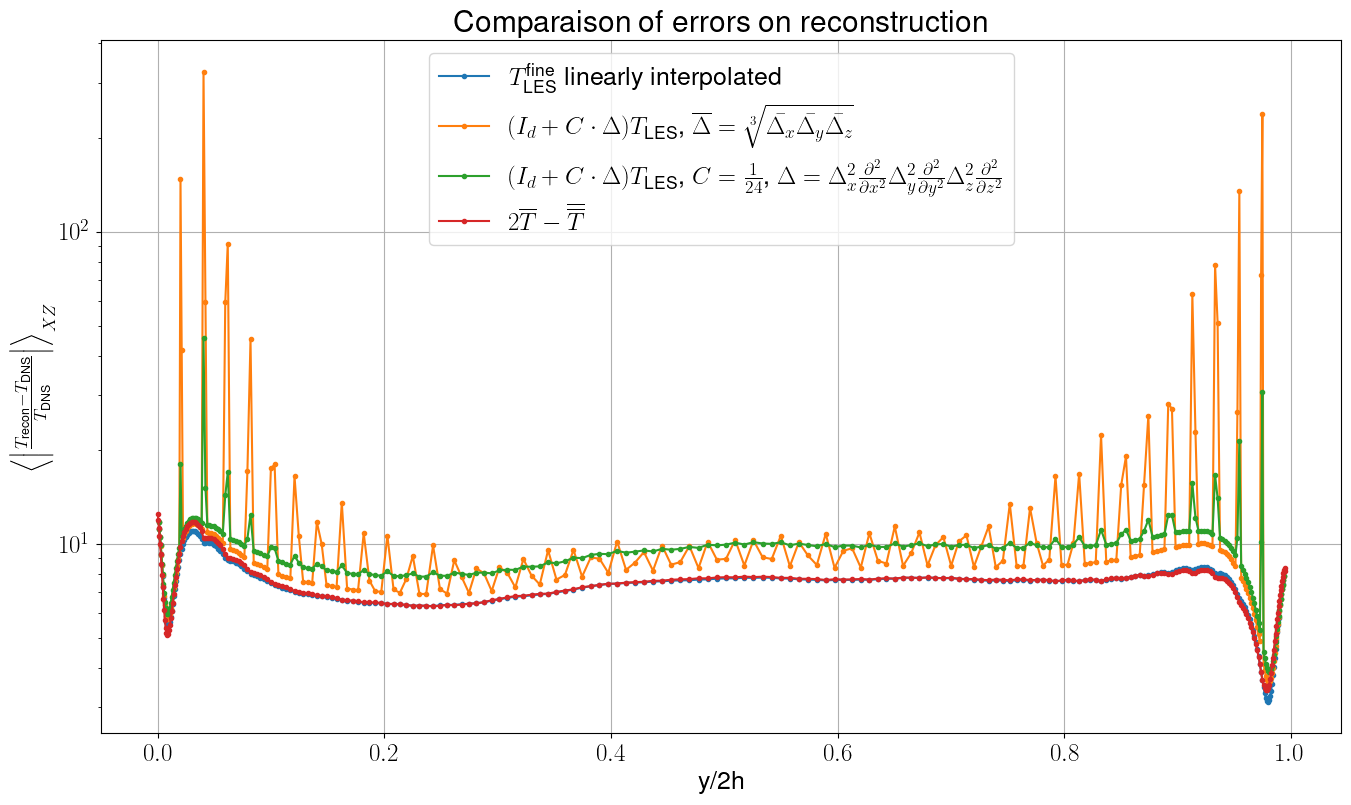

In [24]:
normalized_k = coord[-1]/(2*delta)
fig = plt.figure(figsize=(16,9))
plt.semilogy(
    normalized_k[inner],
    eps_profile_lin_interp[inner],
    "-o",
    markersize=3,
    label=r"$T_{\text{LES}}^\text{fine}$ linearly interpolated"
)

plt.semilogy(
    normalized_k[inner],
    eps_profile_recon_lap1,
    "-o",
    markersize=3,

    label=r"$(I_d + C \cdot \Delta) T_{\text{LES}}$, "
    r"$\overline{\Delta} = \sqrt[3]{\bar{\Delta_x} \bar{\Delta_y} \bar{\Delta_z}}$"
)

plt.semilogy(
    normalized_k[inner],
    eps_profile_recon_lap2,
    "-o",
    markersize=3,

    label=r"$(I_d + C \cdot \Delta) T_{\text{LES}}$, "
    r"$C = \frac{1}{24}$, $\Delta = \Delta_x ^2\frac{\partial ^2}{\partial x^2} \Delta_y^2\frac{\partial ^2}{\partial y^2} \Delta_z^2\frac{\partial ^2}{\partial z^2}$ "
)

plt.semilogy(
    normalized_k,
    error_profile_scale_sim,
    "-o",
    markersize=3,

    label=r"$2\overline{T} - \overline{\overline{T}}$"
)


plt.title("Comparaison of errors on reconstruction")
plt.xlabel("y/2h")
plt.ylabel(r"$\Big\langle \Big| \frac{T_{\text{recon}} - T_{\text{DNS}}}{T_{\text{DNS}}} \Big| \Big \rangle _{XZ}$")
plt.legend()
plt.grid(True)

plt.show()


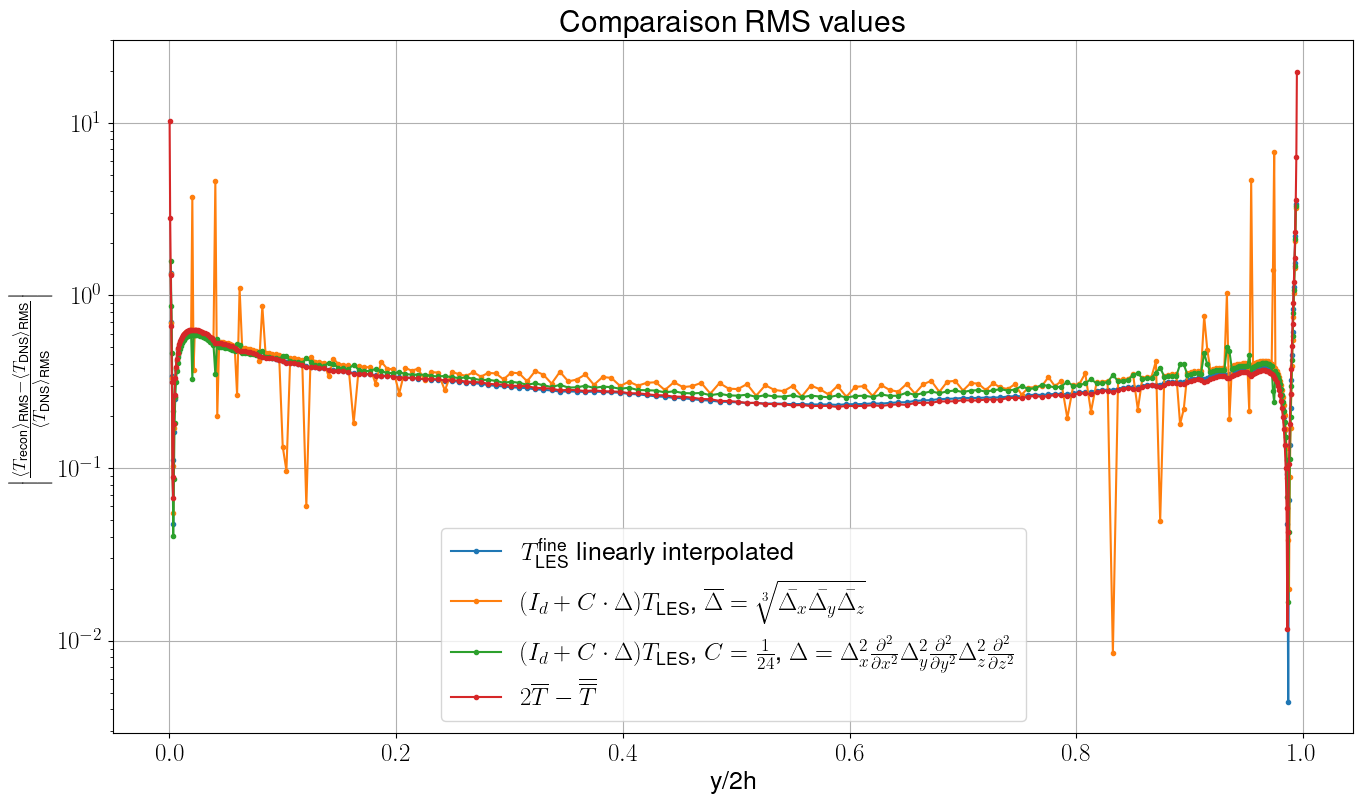

In [25]:
fig = plt.figure(figsize=(16,9))
plt.semilogy(
    normalized_k[inner],
    rms_error_profile_lin_interp[inner],
    "-o",
    markersize=3,
    label=r"$T_{\text{LES}}^\text{fine}$ linearly interpolated"
)

plt.semilogy(
    normalized_k[inner],
    rms_error_profile_lap1,
    "-o",
    markersize=3,

    label=r"$(I_d + C \cdot \Delta) T_{\text{LES}}$, "
    r"$\overline{\Delta} = \sqrt[3]{\bar{\Delta_x} \bar{\Delta_y} \bar{\Delta_z}}$"
)

plt.semilogy(
    normalized_k[inner],
    rms_error_profile_lap2,
    "-o",
    markersize=3,

    label=r"$(I_d + C \cdot \Delta) T_{\text{LES}}$, "
    r"$C = \frac{1}{24}$, $\Delta = \Delta_x ^2\frac{\partial ^2}{\partial x^2} \Delta_y^2\frac{\partial ^2}{\partial y^2} \Delta_z^2\frac{\partial ^2}{\partial z^2}$ "
)

plt.semilogy(
    normalized_k,
    rms_error_profile_scale_sim,
    "-o",
    markersize=3,

    label=r"$2\overline{T} - \overline{\overline{T}}$"
)

#, grad_error_profile_scale_sim


plt.title("Comparaison RMS values")
plt.xlabel("y/2h")
plt.ylabel(r"$ \Big|  \frac{\langle T_{\text{recon}}\rangle _{\text{RMS}} - \langle  T_{\text{DNS}} \rangle_{\text{RMS}} }{ \langle  T_{\text{DNS}} \rangle_{\text{RMS}} } \Big|  $")
plt.legend()
plt.grid(True)

plt.show()


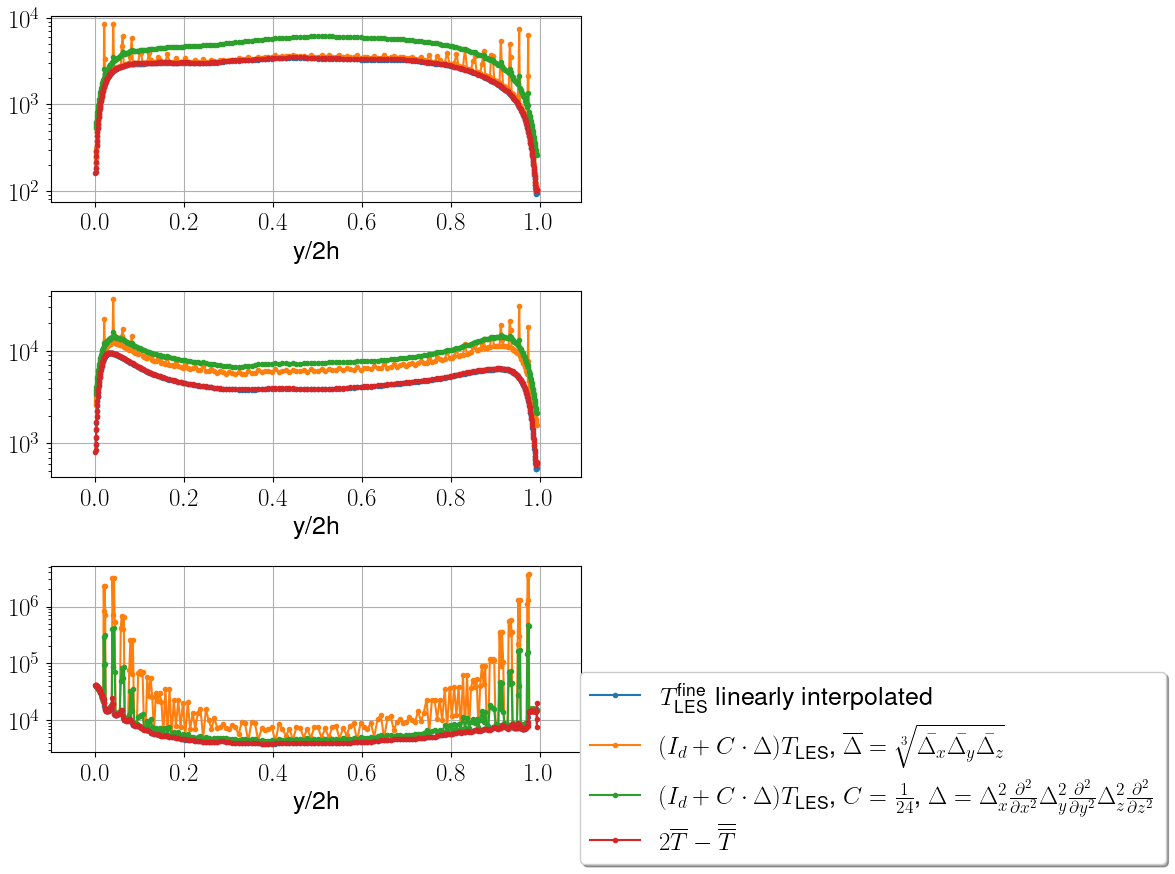

In [26]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize = (16,9))
axs = axs.flatten()
for ax, lin_interp, lap1, lap2, scale_sim in zip(axs, grad_error_profile_lin_interp, grad_error_profile_lap1, grad_error_profile_lap2, grad_error_profile_scale_sim):
    ax.semilogy(
        normalized_k[inner],
        lin_interp[inner],
        "-o",
        markersize=3,
        label=r"$T_{\text{LES}}^\text{fine}$ linearly interpolated"
    )

    ax.semilogy(
        normalized_k[inner],
        lap1,
        "-o",
        markersize=3,

        label=r"$(I_d + C \cdot \Delta) T_{\text{LES}}$, "
        r"$\overline{\Delta} = \sqrt[3]{\bar{\Delta_x} \bar{\Delta_y} \bar{\Delta_z}}$"
    )

    ax.semilogy(
        normalized_k[inner],
        lap2,
        "-o",
        markersize=3,

        label=r"$(I_d + C \cdot \Delta) T_{\text{LES}}$, "
        r"$C = \frac{1}{24}$, $\Delta = \Delta_x ^2\frac{\partial ^2}{\partial x^2} \Delta_y^2\frac{\partial ^2}{\partial y^2} \Delta_z^2\frac{\partial ^2}{\partial z^2}$ "
    )
    
    ax.semilogy(
        normalized_k,
        scale_sim,
        "-o",
        markersize=3,

        label=r"$2\overline{T} - \overline{\overline{T}}$"
    )
    

    # ax.set_ylim([10**2, 10**7])
    ax.margins(x=.1, y=.05)
    ax.set_xlabel(r"y/2h")
    # ax.set_ylabel(r"$ \Big|  \frac{\langle T_{\text{recon}} \rangle _{XZ} - \langle T_{\text{DNS}} \rangle _{XZ} }{\langle  T_{\text{DNS}} \rangle _{XZ} } \Big|  $")
    ax.grid(True)
ax.legend(loc='upper center', bbox_to_anchor=(1.55, 0.5), fancybox=True, shadow=True)
plt.tight_layout()
